In [97]:
import numpy as np
import pandas as pd
import random
import csv
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import imageio

import geopandas as gpd
import shapefile
from json import dumps
import fiona
from pyproj import Proj#, transform
import pyproj

import shapely
from shapely.geometry import Polygon
from shapely.geometry import shape
from functools import partial
from shapely.ops import transform
from shapely.strtree import STRtree

from scipy import stats

# Process manually-labeled parcels

## Individual parcels

In [31]:
geometries = pd.read_csv('../mount/data/crowdsourced_labels/india_fields_sherrie_seed0_geometries.csv')

In [32]:
geometries

,system:index,.geo
0,0,"{""type"":""MultiPolygon"",""coordinates"":[[[[74.54..."


In [34]:
polygons = []
for geom in eval(geometries['.geo'][0])['coordinates']:
    polygons.append(Polygon(geom[0]))

In [36]:
len(polygons)

90

In [29]:
labels = pd.read_csv('../mount/data/crowdsourced_parcels/india_fields_sherrie_seed0_ms1616055609.csv')

In [30]:
labels

,system:index,country,covertype_pt_label,covertype_pt_number,covertype_ti_label,covertype_ti_number,last_updated,lat,lon,pointid,subregion,user,.geo
0,0,india,crop_field,1,more_than_50,1,1616055769700,18.236439,74.544895,P69283606MS1616055609,maharashtra: 1%,none,NaN
1,1,india,veg_other,3,less_than_50,2,1616055833152,21.505512,79.513950,P56408376MS1616055609,maharashtra: 1%,none,NaN
2,2,india,veg_other,3,more_than_50,1,1616055894415,20.586088,73.497629,P3851236MS1616055609,maharashtra: 1%,none,NaN
3,3,india,veg_other,3,more_than_50,1,1616055975867,17.637859,73.363393,P72164892MS1616055609,maharashtra: 1%,none,NaN
4,4,india,crop_field,1,more_than_50,1,1616056031046,20.307461,76.995911,P67706032MS1616055609,maharashtra: 1%,none,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,india,veg_other,3,less_than_50,2,1616055645053,19.693010,76.421913,P37012809MS1616055609,maharashtra: 1%,none,NaN
196,196,india,veg_other,3,less_than_50,2,1616055645053,20.473872,74.118533,P75599604MS1616055609,maharashtra: 1%,none,NaN
197,197,india,veg_other,3,less_than_50,2,1616055645053,15.988154,73.839558,P64090209MS1616055609,maharashtra: 1%,none,NaN
198,198,india,veg_other,3,less_than_50,2,1616055645053,18.046718,76.179290,P14008043MS1616055609,maharashtra: 1%,none,NaN


## Entire Planet images labeled

In [47]:
label_00126 = pd.read_csv('../mount/data/india_parcels/00126_labels.csv')
label_00064_1 = pd.read_csv('../mount/data/india_parcels/00064_labels_1.csv')
label_00064_2 = pd.read_csv('../mount/data/india_parcels/00064_labels_2.csv')

In [48]:
print(len(eval(label_00064_1['.geo'][0])['geometries']))
print(len(eval(label_00064_2['.geo'][0])['coordinates']))
print(len(eval(label_00126['.geo'][0])['coordinates']))

663
352
623


In [51]:
# create geopandas dataframe
image_ids = []
polygons = []

for polygon in eval(label_00126['.geo'][0])['coordinates']:
    pg = Polygon(polygon[0])
    polygons.append(pg)
    image_ids.append('00126')

for polygon in eval(label_00064_1['.geo'][0])['geometries']:
    pg = Polygon(polygon['coordinates'][0])
    polygons.append(pg)
    image_ids.append('00064')
    
for polygon in eval(label_00064_2['.geo'][0])['coordinates']:
    pg = Polygon(polygon[0])
    polygons.append(pg)
    image_ids.append('00064')
    
labels = pd.DataFrame({
    'image_id': image_ids,
    'polygon_id': np.arange(len(polygons)),
    'geometry': polygons
})

gdf = gpd.GeoDataFrame(labels, geometry='geometry')

In [58]:
gdf.to_file("../mount/data/india_parcels/india_parcels.shp")
gdf.head()

,image_id,polygon_id,geometry
0,00126,0,"POLYGON ((76.53260 30.09696, 76.53327 30.09696..."
1,00126,1,"POLYGON ((76.53259 30.09643, 76.53326 30.09642..."
2,00126,2,"POLYGON ((76.53256 30.09589, 76.53324 30.09587..."
3,00126,3,"POLYGON ((76.53326 30.09587, 76.53396 30.09584..."
4,00126,4,"POLYGON ((76.53255 30.09538, 76.53289 30.09537..."


In [60]:
# get area
areas = gpd.read_file("../mount/data/india_parcels/india_parcels_with_area.shp")

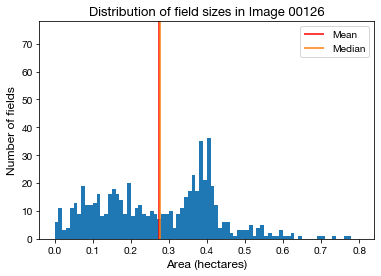

Mean area: 0.273
Median area: 0.276


In [112]:
image_id = '00126'
mean = (areas[areas['image_id'] == image_id]['area'] / 1e4).mean()
median = (areas[areas['image_id'] == image_id]['area'] / 1e4).median()

fs = 12
plt.hist(areas[areas['image_id'] == image_id]['area'] / 1e4, bins=np.linspace(0, 0.8, 81))
plt.vlines(mean, ymin=0, ymax=100, color='red')
plt.vlines(median, ymin=0, ymax=100, color='C1')
plt.title('Distribution of field sizes in Image {}'.format(image_id), fontsize=fs+1)
plt.xlabel('Area (hectares)', fontsize=fs)
plt.ylabel('Number of fields', fontsize=fs)
plt.ylim([0, 78])
plt.legend(['Mean', 'Median'])
plt.show()

print("Mean area: {:0.3f}".format(mean))
print("Median area: {:0.3f}".format(median))

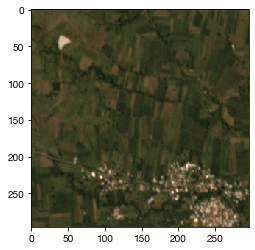

In [24]:
img_00064 = imageio.imread('../data/planet/india/monthly_mosaics_renamed_clipped_merged/2019_10/00064_2019_10.tif')
plt.imshow(img_00064)
plt.show()

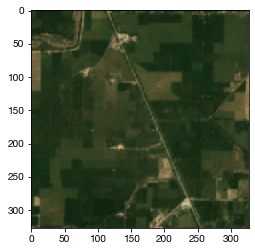

In [25]:
img_00126 = imageio.imread('../data/planet/india/monthly_mosaics_renamed_clipped_merged/2019_10/00126_2019_10.tif')
plt.imshow(img_00126)
plt.show()

## GeoWiki labels

In [113]:
label_960228 = pd.read_csv('../mount/data/india_parcels/geowiki_960228_labels.csv')
print(len(eval(label_960228['.geo'][0])['coordinates']))

266


In [119]:
polygon

[[[75.300165204973, 21.206416680173252],
  [75.30033150193192, 21.207276876727388],
  [75.29902258393265, 21.207606950819013],
  [75.29857733723618, 21.206796767640657],
  [75.300165204973, 21.206416680173252]]]

In [122]:
# create geopandas dataframe
image_ids = []
polygons = []

for polygon in eval(label_960228['.geo'][0])['coordinates']:
    pg = Polygon(polygon[0])
    polygons.append(pg)
    image_ids.append('960228')
    
labels = pd.DataFrame({
    'image_id': image_ids,
    'polygon_id': np.arange(len(polygons)),
    'geometry': polygons
})

gdf = gpd.GeoDataFrame(labels, geometry='geometry')

In [123]:
gdf.to_file("../mount/data/india_parcels/geowiki_parcels.shp")
gdf.head()

,image_id,polygon_id,geometry
0,960228,0,"POLYGON ((75.30397 21.20121, 75.30380 21.20043..."
1,960228,1,"POLYGON ((75.30308 21.20030, 75.30372 21.20015..."
2,960228,2,"POLYGON ((75.30248 21.20044, 75.30307 21.20030..."
3,960228,3,"POLYGON ((75.30115 21.20067, 75.30175 21.20055..."
4,960228,4,"POLYGON ((75.30574 21.20007, 75.30591 21.20001..."


In [124]:
gdf.shape

(266, 3)

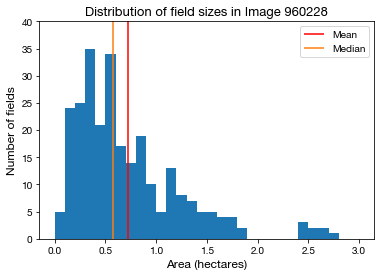

Mean area: 0.725
Median area: 0.576


In [133]:
# get area
areas = gpd.read_file("../mount/data/india_parcels/india_geowiki_parcels_with_area.shp")

image_id = '960228'
mean = (areas[areas['image_id'] == image_id]['area'] / 1e4).mean()
median = (areas[areas['image_id'] == image_id]['area'] / 1e4).median()

fs = 12
plt.hist(areas[areas['image_id'] == image_id]['area'] / 1e4, bins=np.linspace(0, 3, 31))
plt.vlines(mean, ymin=0, ymax=100, color='red')
plt.vlines(median, ymin=0, ymax=100, color='C1')
plt.title('Distribution of field sizes in Image {}'.format(image_id), fontsize=fs+1)
plt.xlabel('Area (hectares)', fontsize=fs)
plt.ylabel('Number of fields', fontsize=fs)
plt.ylim([0, 40])
plt.legend(['Mean', 'Median'])
plt.show()

print("Mean area: {:0.3f}".format(mean))
print("Median area: {:0.3f}".format(median))